<a href="https://colab.research.google.com/github/xu-pu/colab-notebooks/blob/master/Modeling_Course_24_10_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Course 24.10.2023

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp

# Mechanistic v.s. Descriptive

Mechanistic as a dynamic system:

$$
\dot{x} = - \frac{x}{\tau}
$$

Descriptive as a solution of ODE:

$$
x(t) = x_0 e^{-t/ \tau}
$$

The curves are the same, but qualitively not equivalent.

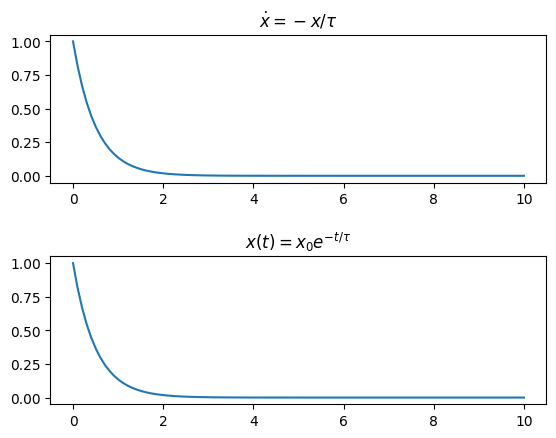

In [167]:
tau = 0.5
x0 = 1.
duration = 10
fps = 10
vt = np.linspace(0,duration,duration*fps)

# mechanistic

ivp_result = solve_ivp(
    lambda t, x : -x/tau,
    (0, duration),
    [x0],
    t_eval=vt
)

vx_mech = ivp_result.y[0,:]

# descriptive

vx_desc = x0 * np.exp(-vt/tau)

# plot

fig, axes = plt.subplots(2,1, gridspec_kw={'hspace': 0.5, 'wspace': 0.})
axes[0].set_title(r'$\dot{x} = - x / \tau$')
axes[0].plot(vt, vx_mech)
axes[1].set_title(r'$x(t) = x_0 e^{-t/ \tau}$')
axes[1].plot(vt, vx_desc)
plt.show()

# ① Linear Dynamics

Only three things could happen in a linear dynamic system:

- explode exponentially
- decay exponentially
- oscillate

# ② Leaky Integrator

$$
\tau \dot{x} + x = I
$$



In [168]:
# Naive unit impulse function
def unit_impulse(t, dt=1.0, onset=0.0):
  outset = onset+dt
  peak = 1.0/dt
  return np.logical_and(t>=onset, t<=outset).astype(float) * peak

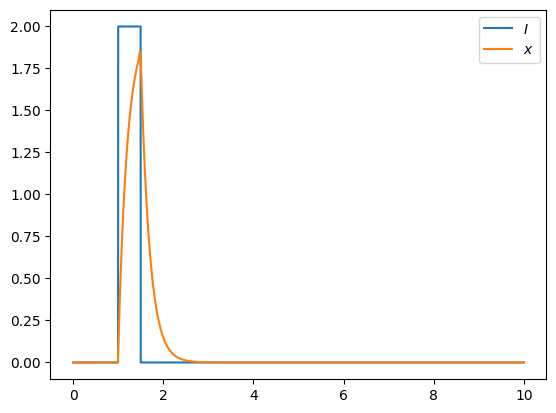

In [169]:
tau = 0.2
x0 = 0
duration = 10
fps = 1000
vt = np.linspace(0, duration, duration*fps)

I = lambda t : unit_impulse(t, dt=0.5, onset=1)
#I = lambda t : unit_impulse(t, dt=0.5, onset=1) + unit_impulse(t, dt=0.15, onset=2)

xdot = lambda t, x : (I(t) - x)/tau

ivp_result = solve_ivp(
    xdot,
    (0, duration),
    [x0],
    t_eval=vt
)

vx = ivp_result.y[0,:]

plt.plot(vt, I(vt), label=r'$I$')
plt.plot(vt, vx, label=r'$x$')
plt.legend()
plt.show()

# ③ Stacked Leaky Integrator

$$
\tau_1 \dot{x_1} + x_1 = I
$$

$$
\tau_2 \dot{x_2} + x_2 = x_1
$$

$$
\tau_3 \dot{x_3} + x_3 = x_2
$$

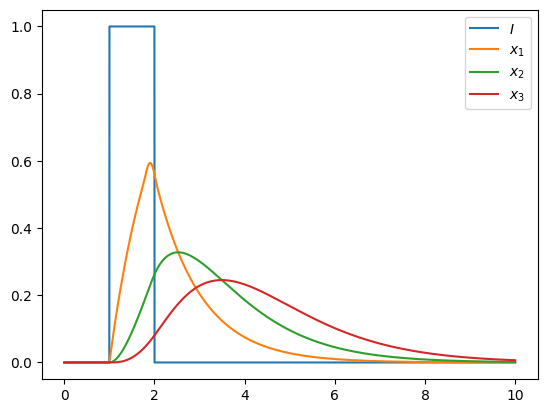

In [170]:
tau1 = 1
tau2 = 1
tau3 = 1
x0 = 0
duration = 10
fps = 1000
vt = np.linspace(0, duration, duration*fps)

I = lambda t : unit_impulse(t, dt=1, onset=1)
#I = lambda t : unit_impulse(t, dt=0.5, onset=1) + unit_impulse(t, dt=0.5, onset=4)

xdot = lambda t, x : [
    (I(t) - x[0])/tau1,
    (x[0] - x[1])/tau2,
    (x[1] - x[2])/tau3
]

ivp_result = solve_ivp(
    xdot,
    (0, duration),
    [0,0,0],
    t_eval=vt
)

vx1 = ivp_result.y[0,:]
vx2 = ivp_result.y[1,:]
vx3 = ivp_result.y[2,:]

plt.plot(vt, I(vt), label=r'$I$')
plt.plot(vt, vx1, label=r'$x_1$')
plt.plot(vt, vx2, label=r'$x_2$')
plt.plot(vt, vx3, label=r'$x_3$')
plt.legend()
plt.show()

# ④ Harmoic Oscillator

# Exercise A - Vaccination

Model the phenomenon:
After taking a covid vaccine, the effect kicks in after 2 weeks. Then it wears out after 6 month.


__Solution__
$x_2$ measures the protection agains covid. It's a stacked leaky integrator.
$$
\tau_1 \dot{x_1} + x_1 = I
$$

$$
\tau_2 \dot{x_2} + x_2 = x_1
$$
where $I$ is the vaccine dose, and $x_1$ is a latent variable (let's say,  "immune response").

The protection is active if $x_2 > \lambda$. Set $\tau_1$ and $\tau_2$ so that it matches the 2 week 2 month crossing points.

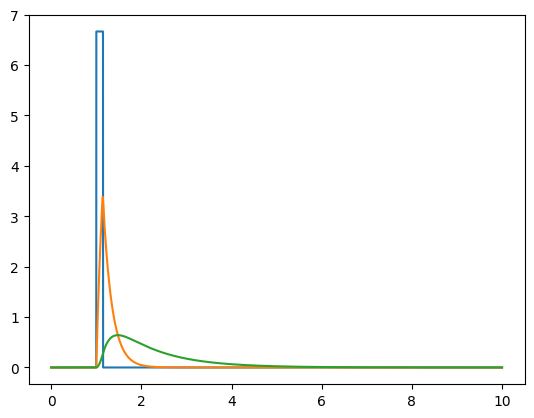

In [171]:
tau1 = 0.2
tau2 = 1
x0 = 0
duration = 10
fps = 10000
vt = np.linspace(0, duration, duration*fps)

I = lambda t : unit_impulse(t, dt=0.15, onset=1)
#I = lambda t : unit_impulse(t, dt=0.5, onset=1) + unit_impulse(t, dt=0.5, onset=4)

xdot = lambda t, x : [
    (I(t) - x[0])/tau1,
    (x[0] - x[1])/tau2
]

ivp_result = solve_ivp(
    xdot,
    (0, duration),
    [0,0],
    t_eval=vt
)

vx1 = ivp_result.y[0,:]
vx2 = ivp_result.y[1,:]


#plt.gca().set_ylim((-0.05,1))
plt.plot(vt, I(vt))
plt.plot(vt, vx1)
plt.plot(vt, vx2)


plt.show()

__after thought for the vaccination exercise__

find $\tau_1$ and $\tau_2$ that matches the 2 weeks / 6 month numerically is not trivial.

We probabaly need to stack more leaky integrators (more than 2) to induce euough delay and smoothing.

# Exercise B - Pandemic

Gov try to get the pandemic under control. If there are more reported cases,  the control will be more strict, the measures will be relaxed when there are less reported cases.

Model this phenomenon.

__Solution:__ $I$ is the real infection number, $R$ is the reported case number.

$$
\tau_I \dot{I} = I - a R
$$

$$
\tau_R \dot{R} + R = I
$$

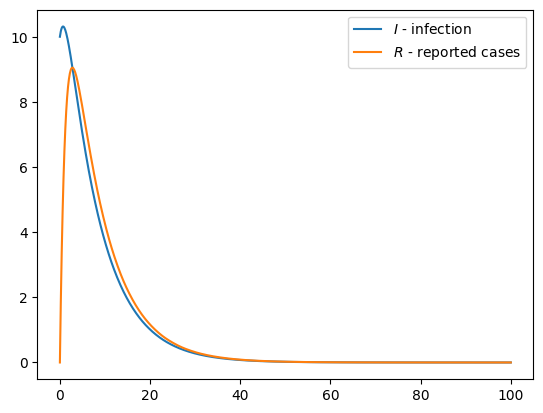

In [172]:
tauI = 10
tauR = 1
a = 2
x0 = 10 # initial cases
duration = 100
fps = 10
vt = np.linspace(0, duration, duration*fps)

xdot = lambda t, x : [
    (x[0] - a * x[1])/tauI,
    (x[0] - x[1])/tauR
]

ivp_result = solve_ivp(
    xdot,
    (0, duration),
    [x0,0],
    t_eval=vt
)

vI = ivp_result.y[0,:]
vR = ivp_result.y[1,:]

plt.plot(vt, vI, label=r'$I$ - infection')
plt.plot(vt, vR, label=r'$R$ - reported cases')
plt.legend()
plt.show()